In [1]:
# Cell 1: Imports and Setup for Active Users Forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8')

print("All libraries imported successfully for Active Users Forecasting!")


All libraries imported successfully for Active Users Forecasting!


In [2]:
# Cell 2: Data Loading and Active Users Data Preparation
# Load the dataset
df = pd.read_csv('D:\infosysspringboard projects\project1-1stmilestine\AZURE_BACKEND_TEAM-B\data\processed\cleaned_merged.csv', parse_dates=['date'])

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check for active users data
print(f"\nActive Users Statistics:")
print(f"Mean active users: {df['users_active'].mean():.2f}")
print(f"Min active users: {df['users_active'].min()}")
print(f"Max active users: {df['users_active'].max()}")
print(f"Standard deviation: {df['users_active'].std():.2f}")

# Display first few rows focusing on users_active
print("\nFirst few rows of the dataset:")
df.head()


Dataset shape: (1080, 9)
Columns: ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']

Active Users Statistics:
Mean active users: 352.69
Min active users: 200
Max active users: 499
Standard deviation: 86.28

First few rows of the dataset:


,date,region,resource_type,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,2023-01-01,East US,VM,88,1959,470,104.97,0.99,1
1,2023-01-01,East US,Storage,92,1595,388,104.97,0.99,1
2,2023-01-01,East US,Container,70,621,414,104.97,0.99,1
3,2023-01-01,West US,VM,60,1982,287,104.97,0.99,1
4,2023-01-01,West US,Storage,85,1371,351,104.97,0.99,1


In [3]:
# Cell 3: Region-wise Active Users Data Aggregation
# Aggregate by region and date - focusing on users_active
region_daily_users = (df
                     .groupby(['region', 'date'])
                     .agg({
                         'usage_cpu': ['mean'],
                         'usage_storage': ['mean'],
                         'users_active': ['sum'],  # Sum active users across resource types
                         'economic_index': ['first'],
                         'cloud_market_demand': ['first'],
                         'holiday': ['max']
                     })
                     .round(2)
                     .reset_index())

# Flatten column names
region_daily_users.columns = ['region', 'date', 'usage_cpu', 'usage_storage', 
                              'users_active', 'economic_index', 'cloud_market_demand', 'holiday']

print(f"Aggregated data shape: {region_daily_users.shape}")
print("\nActive users summary by region:")
for region in region_daily_users['region'].unique():
    region_data = region_daily_users[region_daily_users['region'] == region]
    print(f"{region}: Mean={region_data['users_active'].mean():.0f}, "
          f"Min={region_data['users_active'].min()}, "
          f"Max={region_data['users_active'].max()}")

region_daily_users.head()


Aggregated data shape: (360, 8)

Active users summary by region:
East US: Mean=1062, Min=659, Max=1429
North Europe: Mean=1040, Min=685, Max=1470
Southeast Asia: Mean=1068, Min=626, Max=1324
West US: Mean=1062, Min=710, Max=1410


,region,date,usage_cpu,usage_storage,users_active,economic_index,cloud_market_demand,holiday
0,East US,2023-01-01,83.33,1391.67,1272,104.97,0.99,1
1,East US,2023-01-02,91.67,1456.67,800,106.48,1.15,0
2,East US,2023-01-03,78.33,1138.33,1285,97.66,0.98,0
3,East US,2023-01-04,75.00,881.00,872,115.79,1.08,0
4,East US,2023-01-05,86.67,1234.00,1017,95.31,1.05,0


East US: (90, 6)


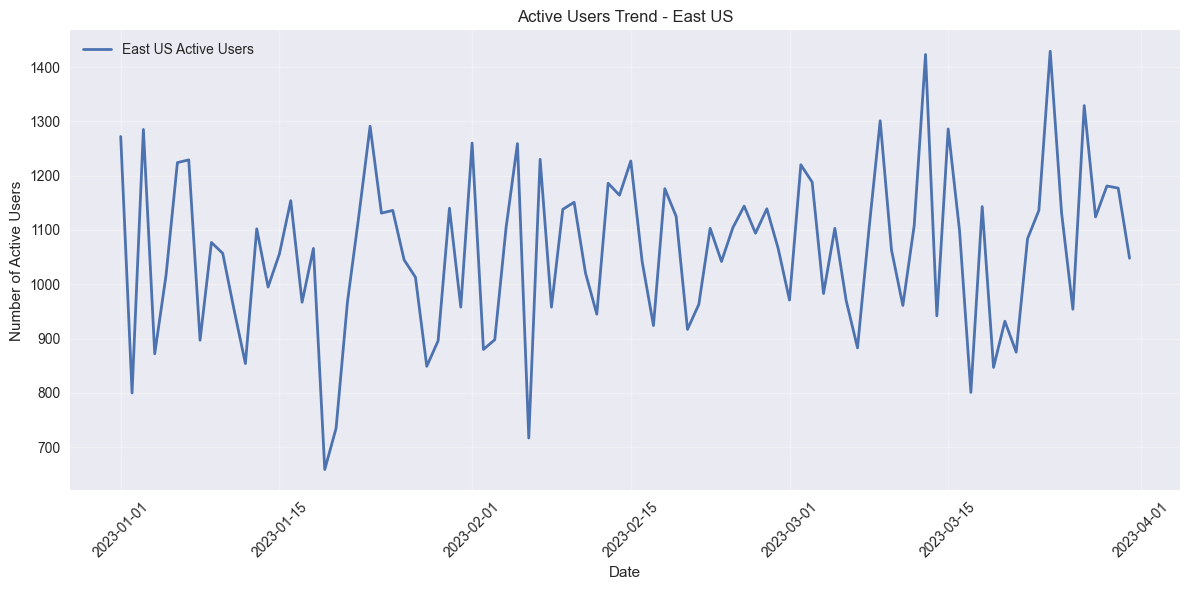

North Europe: (90, 6)


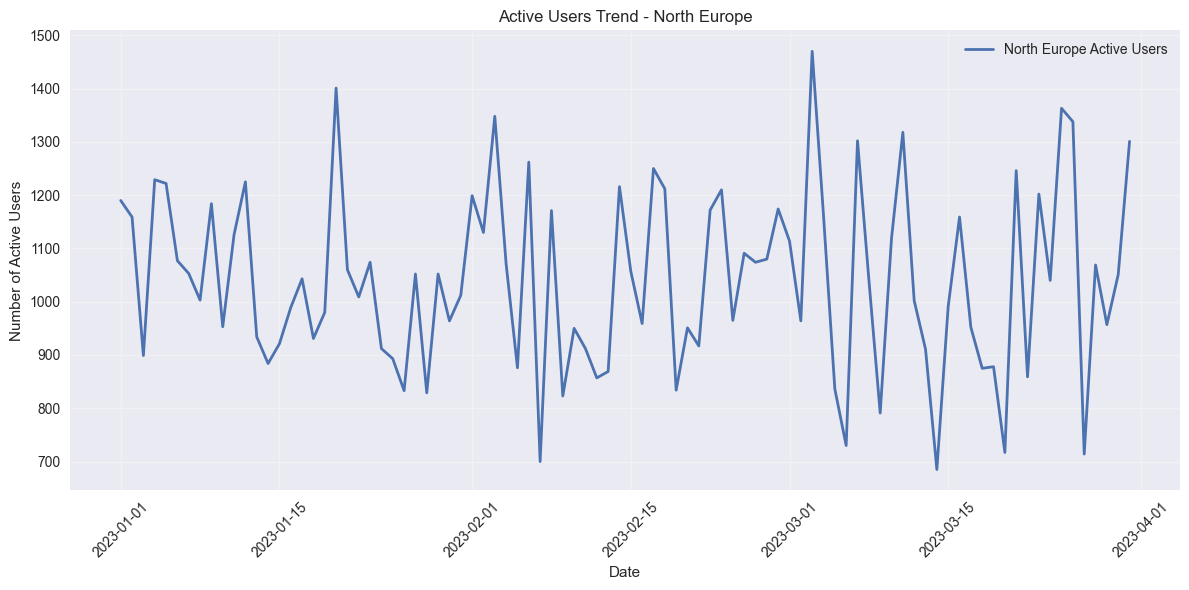

Southeast Asia: (90, 6)


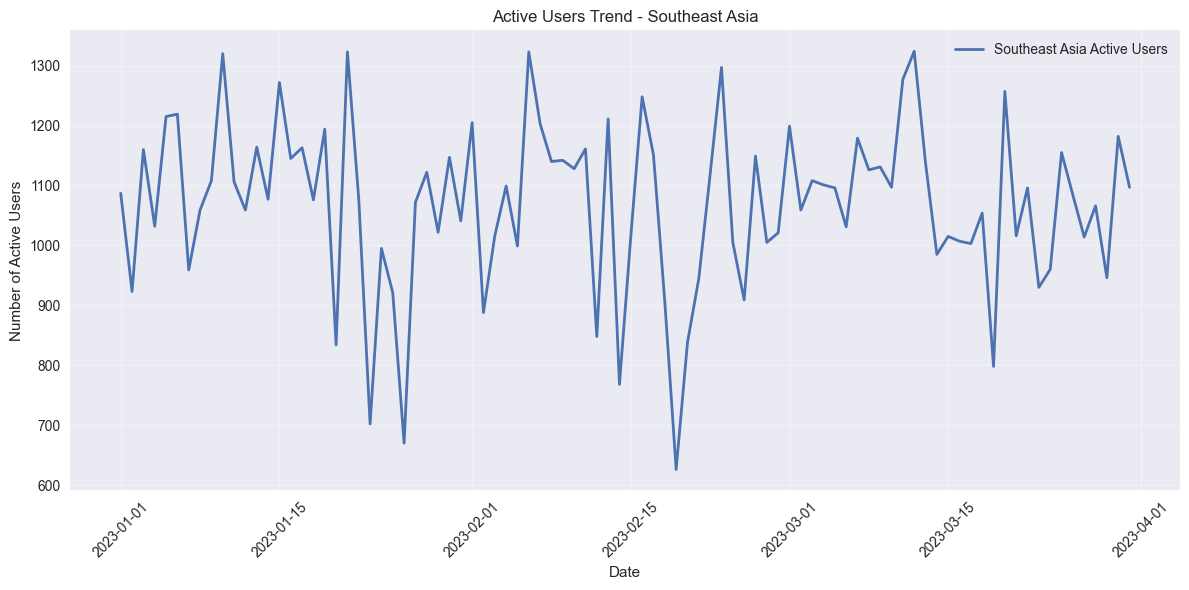

West US: (90, 6)


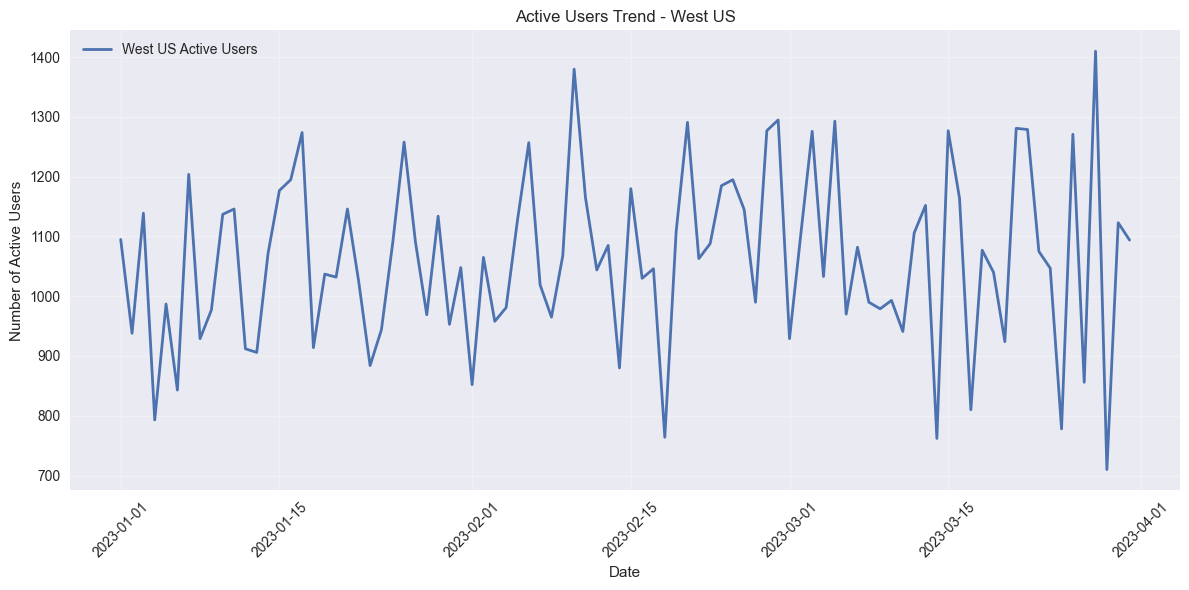


Region-specific time series created for Active Users!


In [4]:
# Cell 4: Create Region-Specific Time Series for Active Users
region_dfs_users = {}

for region, grp in region_daily_users.groupby('region'):
    # Set date as index and create daily frequency time series
    ts = grp.set_index('date').drop('region', axis=1).asfreq('D')
    region_dfs_users[region] = ts
    print(f"{region}: {ts.shape}")
    
    # Plot active users trend for each region
    plt.figure(figsize=(12, 6))
    plt.plot(ts.index, ts['users_active'], label=f'{region} Active Users', linewidth=2)
    plt.title(f'Active Users Trend - {region}')
    plt.xlabel('Date')
    plt.ylabel('Number of Active Users')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nRegion-specific time series created for Active Users!")


In [5]:
# Cell 5: Train-Test Split Function for Active Users
def train_test_split_ts_users(ts, train_frac=0.8):
    """
    Split time series data for active users forecasting
    
    Parameters:
    ts: Time series dataframe
    train_frac: Fraction of data to use for training
    
    Returns:
    train_data, test_data
    """
    n = len(ts)
    split = int(train_frac * n)
    return ts.iloc[:split], ts.iloc[split:]

# Test the function
print("Train-Test split function for Active Users ready!")


Train-Test split function for Active Users ready!


In [6]:
# Cell 6: ARIMA Model for Active Users Forecasting
from statsmodels.tsa.arima.model import ARIMA

# Store ARIMA results for active users
arima_results_users = {}

def compute_metrics_users(true_vals, preds):
    """Compute evaluation metrics for active users forecasting"""
    rmse = np.sqrt(mean_squared_error(true_vals, preds))
    mae = mean_absolute_error(true_vals, preds)
    mape = np.mean(np.abs((true_vals - preds) / true_vals)) * 100
    return rmse, mae, mape

print("ARIMA Model Results for Active Users:")
print("-" * 40)

for region, ts in region_dfs_users.items():
    # Split data for active users
    split = int(0.8 * len(ts))
    
    if region == 'East US':
        # For East US, apply differencing if trend is strong
        ts_diff = ts['users_active'].diff().dropna()
        train_ts = ts_diff.iloc[:split - 1]
        test_ts = ts_diff.iloc[split - 1:]
        
        # Fit ARIMA on differenced series
        model = ARIMA(train_ts, order=(5, 0, 0)).fit()
        preds_diff = model.forecast(steps=len(test_ts))
        
        # Reconstruct level forecast
        last_train = ts['users_active'].iloc[split - 1]
        arima_preds = np.r_[last_train, preds_diff].cumsum()[1:]
        actual = ts['users_active'].iloc[split:]
        
    else:
        # Standard ARIMA on original series for other regions
        train_ts = ts['users_active'].iloc[:split]
        test_ts = ts['users_active'].iloc[split:]
        
        model = ARIMA(train_ts, order=(5, 1, 0)).fit()
        arima_preds = model.forecast(steps=len(test_ts))
        actual = test_ts.values
    
    # Compute metrics
    arima_rmse, arima_mae, arima_mape = compute_metrics_users(actual, arima_preds)
    arima_results_users[region] = (model, arima_rmse, arima_mae, arima_mape, actual, arima_preds)
    
    print(f"{region} ARIMA - RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")

print("\nARIMA modeling for Active Users completed!")


ARIMA Model Results for Active Users:
----------------------------------------
East US ARIMA - RMSE: 197.03, MAE: 156.88, MAPE: 16.1%
North Europe ARIMA - RMSE: 221.14, MAE: 186.67, MAPE: 20.2%
Southeast Asia ARIMA - RMSE: 187.07, MAE: 164.42, MAPE: 16.9%
West US ARIMA - RMSE: 205.04, MAE: 167.65, MAPE: 17.2%

ARIMA modeling for Active Users completed!


In [7]:
# Cell 7: XGBoost Model with Rich Features for Active Users Forecasting
xgb_results_users = {}

print("XGBoost Model Results for Active Users:")
print("-" * 42)

for region, ts in region_dfs_users.items():
    # Create feature-rich dataset for active users prediction
    df2 = ts.copy()
    
    # Create lag features and rolling statistics for users_active
    df2['users_active_lag1'] = df2['users_active'].shift(1)
    df2['users_active_lag7'] = df2['users_active'].shift(7)
    df2['users_active_roll7_mean'] = df2['users_active'].rolling(7).mean()
    df2['users_active_roll7_std'] = df2['users_active'].rolling(7).std()
    
    # Create additional features
    df2['dow'] = df2.index.dayofweek  # Day of week
    df2['month'] = df2.index.month    # Month
    df2['day'] = df2.index.day        # Day of month
    
    # Include other variables as features
    df2['usage_cpu_lag1'] = df2['usage_cpu'].shift(1)
    df2['usage_storage_lag1'] = df2['usage_storage'].shift(1)
    
    # Drop rows with NaN values
    df2.dropna(inplace=True)
    
    # Define features for active users prediction
    features = ['users_active_lag1', 'users_active_lag7', 'users_active_roll7_mean', 
                'users_active_roll7_std', 'usage_cpu', 'usage_storage', 
                'usage_cpu_lag1', 'usage_storage_lag1',
                'economic_index', 'cloud_market_demand', 'dow', 'month', 'day', 'holiday']
    
    X, y = df2[features], df2['users_active']
    split = int(0.8 * len(X))
    
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Train XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              verbose=False)
    
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    xgb_results_users[region] = (model, rmse, mae, X_test.index, y_test, preds)
    print(f"{region} XGB - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

print("\nXGBoost modeling for Active Users completed!")


XGBoost Model Results for Active Users:
------------------------------------------
East US XGB - RMSE: 169.86, MAE: 124.64
North Europe XGB - RMSE: 198.29, MAE: 164.30
Southeast Asia XGB - RMSE: 141.89, MAE: 114.71
West US XGB - RMSE: 172.63, MAE: 142.54

XGBoost modeling for Active Users completed!


In [8]:
# Cell 8: Univariate LSTM for Active Users Forecasting
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Store LSTM results for active users
lstm_results_users = {}

# LSTM parameters
n_steps = 30  # Look back window

print("LSTM Model Results for Active Users:")
print("-" * 40)

for region, ts in region_dfs_users.items():
    # Use only users_active feature for univariate LSTM
    seq = ts['users_active'].values.reshape(-1, 1)
    
    # Scale the data
    scaler = MinMaxScaler()
    seq_scaled = scaler.fit_transform(seq)
    
    # Create sequences and targets for LSTM
    Xs, ys = [], []
    
    for i in range(n_steps, len(seq_scaled)):
        Xs.append(seq_scaled[i-n_steps:i, 0])
        ys.append(seq_scaled[i, 0])
    
    Xs, ys = np.array(Xs), np.array(ys)
    
    # Train-test split
    split_idx = int(0.8 * len(Xs))
    X_train_lstm, X_test_lstm = Xs[:split_idx], Xs[split_idx:]
    y_train_lstm, y_test_lstm = ys[:split_idx], ys[split_idx:]
    
    # Reshape for LSTM input (samples, timesteps, features)
    X_train_lstm = X_train_lstm.reshape((len(X_train_lstm), n_steps, 1))
    X_test_lstm = X_test_lstm.reshape((len(X_test_lstm), n_steps, 1))
    
    # Define LSTM model architecture
    lstm_model = Sequential([
        LSTM(64, input_shape=(n_steps, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping callback
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model
    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    
    # Predict and inverse scale
    preds_scaled = lstm_model.predict(X_test_lstm, verbose=0).flatten()
    y_test_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    
    # Compute metrics
    lstm_rmse, lstm_mae, lstm_mape = compute_metrics_users(y_test_inv, preds_inv)
    
    lstm_results_users[region] = (lstm_model, scaler, lstm_rmse, lstm_mae, lstm_mape, 
                                 X_test_lstm, y_test_inv, preds_inv, history)
    
    print(f"{region} LSTM - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")

print("\nLSTM modeling for Active Users completed!")


LSTM Model Results for Active Users:
----------------------------------------
East US LSTM - RMSE: 169.67, MAE: 136.36, MAPE: 11.8%
North Europe LSTM - RMSE: 245.92, MAE: 211.33, MAPE: 19.6%
Southeast Asia LSTM - RMSE: 100.60, MAE: 84.71, MAPE: 7.8%
West US LSTM - RMSE: 217.69, MAE: 186.28, MAPE: 18.1%

LSTM modeling for Active Users completed!


TypeError: '<' not supported between instances of 'XGBRegressor' and 'ARIMAResultsWrapper'

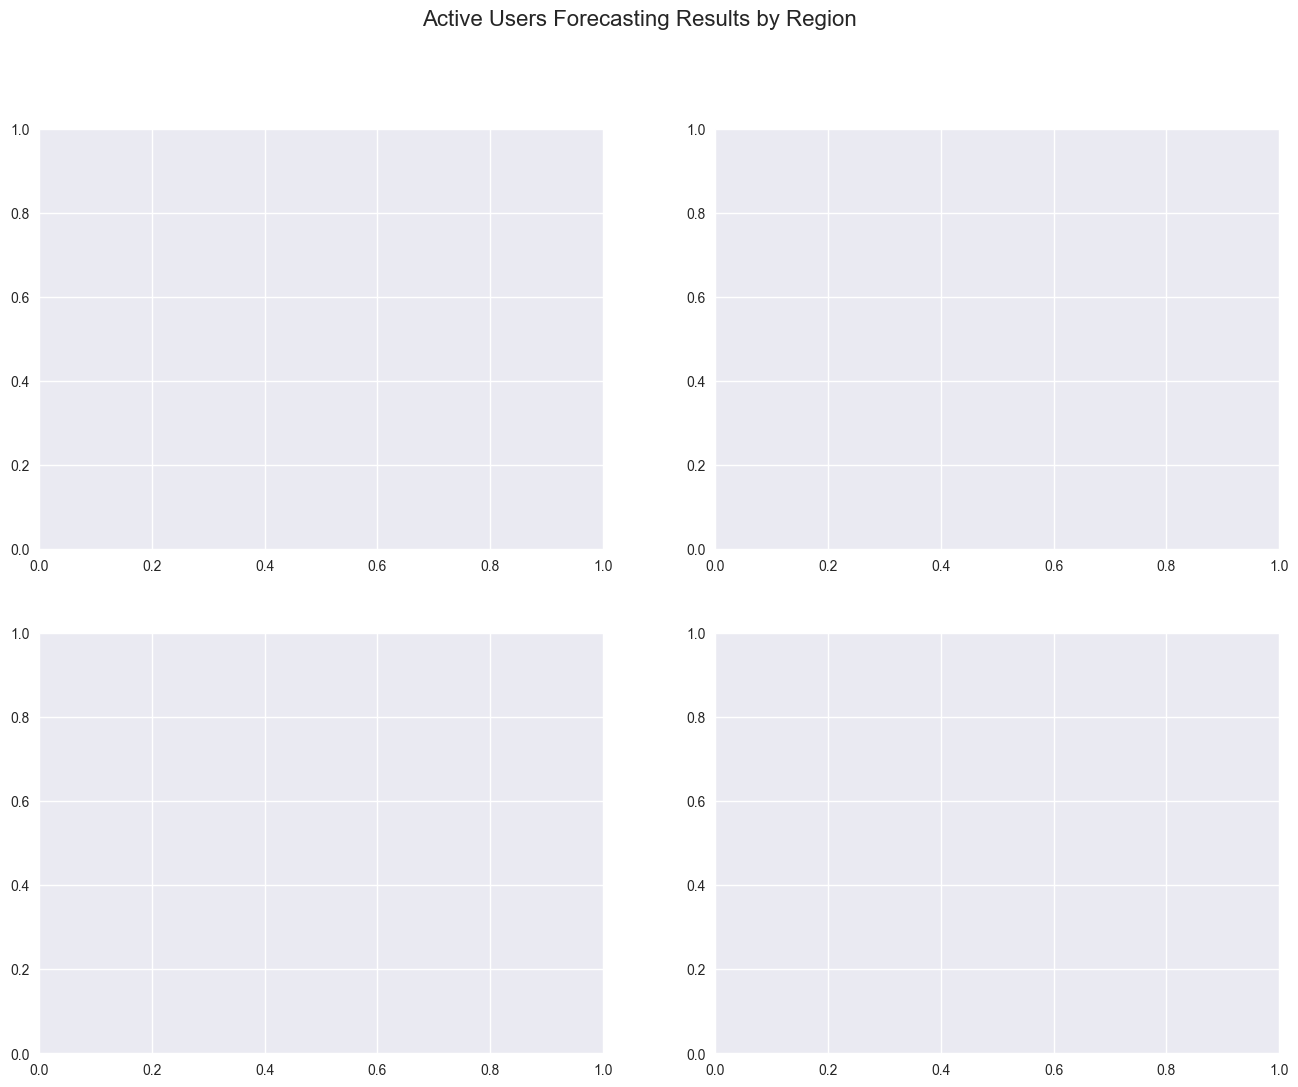

In [9]:
# Cell 9: Model Comparison and Visualization for Active Users
import matplotlib.pyplot as plt
import pandas as pd

# Prepare summary results for active users forecasting
results_users = []

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Active Users Forecasting Results by Region', fontsize=16, y=0.98)

for ax, region in zip(axes.flatten(), region_dfs_users.keys()):
    # Get metrics for the three models in the region
    metrics_users = {
        'ARIMA': arima_results_users[region],  # RMSE
        'XGB': xgb_results_users[region],     # RMSE
        'LSTM': lstm_results_users[region]     # RMSE
    }
    
    # Select best model based on RMSE
    best_model = min(metrics_users, key=metrics_users.get)
    
    # Plot predictions vs actual for active users
    if best_model == 'ARIMA':
        arima_rmse, arima_mae, arima_mape, actual, preds = arima_results_users[region][1:6]
        
        # Handle different data structures for ARIMA predictions
        split = int(0.8 * len(region_dfs_users[region]))
        
        if region == 'East US':
            # For East US, reconstruct forecast similarly as in ARIMA cell
            ts = region_dfs_users[region]['users_active']
            ts_diff = ts.diff().dropna()
            train_ts = ts_diff.iloc[:split - 1]
            test_ts = ts_diff.iloc[split - 1:]
            
            # Get model and reconstruct predictions
            model = arima_results_users[region]
            preds_diff = model.forecast(steps=len(test_ts))
            last_train = ts.iloc[split - 1]
            preds = np.r_[last_train, preds_diff].cumsum()[1:]
            actual = ts.iloc[split:]
        else:
            test = region_dfs_users[region]['users_active'].iloc[split:]
            preds = arima_results_users[region]
            actual = test
        
        ax.plot(range(len(actual)), actual, 'b-', label='Actual', linewidth=2)
        ax.plot(range(len(preds)), preds, 'r--', label='ARIMA', linewidth=2)
        
        # Get remaining metrics for the summary
        xgb_rmse, xgb_mae = xgb_results_users[region][1:3]
        lstm_rmse, lstm_mae, lstm_mape = lstm_results_users[region][2:5]
        
    elif best_model == 'XGB':
        model, xgb_rmse, xgb_mae, idx, y_test, preds = xgb_results_users[region]
        
        ax.plot(range(len(y_test)), y_test, 'b-', label='Actual', linewidth=2)
        ax.plot(range(len(preds)), preds, 'g--', label='XGBoost', linewidth=2)
        
        # Get remaining metrics for summary
        arima_rmse, arima_mae, arima_mape = arima_results_users[region][1:4]
        lstm_rmse, lstm_mae, lstm_mape = lstm_results_users[region][2:5]
        
    else:  # LSTM
        lstm_model, scaler, lstm_rmse, lstm_mae, lstm_mape, X_test, y_test, preds, history = lstm_results_users[region]
        
        ax.plot(range(len(y_test)), y_test, 'b-', label='Actual', linewidth=2)
        ax.plot(range(len(preds)), preds, 'm--', label='LSTM', linewidth=2)
        
        # Get remaining metrics for summary
        arima_rmse, arima_mae, arima_mape = arima_results_users[region][1:4]
        xgb_rmse, xgb_mae = xgb_results_users[region][1:3]
        
        # Get LSTM MAPE if available
        lstm_mape = lstm_results_users[region] if len(lstm_results_users[region]) > 4 else np.nan
    
    ax.set_title(f'{region} - Best: {best_model}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Number of Active Users')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Append summary metrics for this region
    results_users.append({
        'region': region,
        'ARIMA_RMSE': round(arima_rmse, 2),
        'ARIMA_MAE': round(arima_mae, 2),
        'ARIMA_MAPE': round(arima_mape, 2) if isinstance(arima_mape, (float, int)) else np.nan,
        'XGB_RMSE': round(xgb_rmse, 2),
        'XGB_MAE': round(xgb_mae, 2),
        'LSTM_RMSE': round(lstm_rmse, 2),
        'LSTM_MAE': round(lstm_mae, 2),
        'LSTM_MAPE': round(lstm_mape, 2) if isinstance(lstm_mape, (float, int)) else np.nan,
        'Best_Model': best_model
    })

plt.tight_layout()
plt.show()

# Create summary DataFrame and print
results_df_users = pd.DataFrame(results_users).set_index('region')
print("\n" + "="*80)
print("ACTIVE USERS FORECASTING - SUMMARY TABLE")
print("="*80)
print(results_df_users)

# Model performance analysis
print("\n" + "="*50)
print("MODEL PERFORMANCE ANALYSIS FOR ACTIVE USERS:")
print("="*50)

# Count best models
best_models_count = results_df_users['Best_Model'].value_counts()
print("\nBest Model Count:")
for model, count in best_models_count.items():
    print(f"  {model}: {count} regions")

# Average RMSE by model
avg_rmse = {
    'ARIMA': results_df_users['ARIMA_RMSE'].mean(),
    'XGBoost': results_df_users['XGB_RMSE'].mean(),
    'LSTM': results_df_users['LSTM_RMSE'].mean()
}

print(f"\nAverage RMSE across all regions:")
for model, rmse in avg_rmse.items():
    print(f"  {model}: {rmse:.2f}")

print("\nActive Users forecasting model comparison completed!")


In [ ]:
# Cell 10: Feature Importance Analysis for Active Users XGBoost Model
import matplotlib.pyplot as plt

print("Feature Importance Analysis for Active Users Forecasting")
print("="*58)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('XGBoost Feature Importance for Active Users Prediction', fontsize=16)

for ax, region in zip(axes.flatten(), region_dfs_users.keys()):
    # Get XGBoost model for the region
    model, _, _, _, _, _ = xgb_results_users[region]
    
    # Get feature importance
    importance = model.feature_importances_
    
    # Define feature names (same as used in XGBoost training)
    feature_names = ['users_active_lag1', 'users_active_lag7', 'users_active_roll7_mean', 
                    'users_active_roll7_std', 'usage_cpu', 'usage_storage', 
                    'usage_cpu_lag1', 'usage_storage_lag1',
                    'economic_index', 'cloud_market_demand', 'dow', 'month', 'day', 'holiday']
    
    # Sort features by importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=True)
    
    # Plot horizontal bar chart
    ax.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
            color='skyblue', alpha=0.7)
    ax.set_title(f'{region}', fontweight='bold')
    ax.set_xlabel('Feature Importance')
    ax.grid(axis='x', alpha=0.3)
    
    # Rotate y-axis labels for better readability
    ax.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

# Print top 5 features for each region
print("\nTop 5 Most Important Features by Region:")
print("-" * 45)

for region in region_dfs_users.keys():
    model, _, _, _, _, _ = xgb_results_users[region]
    importance = model.feature_importances_
    
    feature_names = ['users_active_lag1', 'users_active_lag7', 'users_active_roll7_mean', 
                    'users_active_roll7_std', 'usage_cpu', 'usage_storage', 
                    'usage_cpu_lag1', 'usage_storage_lag1',
                    'economic_index', 'cloud_market_demand', 'dow', 'month', 'day', 'holiday']
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"\n{region}:")
    for i, (_, row) in enumerate(feature_importance_df.head().iterrows()):
        print(f"  {i+1}. {row['feature']}: {row['importance']:.3f}")

print("\nFeature importance analysis completed!")


In [ ]:
# Cell 11: Comprehensive Model Evaluation for Active Users
import numpy as np
import pandas as pd

def calculate_additional_metrics(actual, predicted):
    """Calculate additional evaluation metrics"""
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Mean Squared Error
    mse = np.mean((actual - predicted) ** 2)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(actual - predicted))
    
    # R-squared (coefficient of determination)
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return {
        'MAPE': mape,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R_squared': r_squared
    }

print("COMPREHENSIVE MODEL EVALUATION FOR ACTIVE USERS")
print("="*55)

# Detailed evaluation for each region and model
detailed_results = []

for region in region_dfs_users.keys():
    print(f"\n{region.upper()} REGION:")
    print("-" * 30)
    
    # ARIMA evaluation
    split = int(0.8 * len(region_dfs_users[region]))
    if region == 'East US':
        ts = region_dfs_users[region]['users_active']
        actual = ts.iloc[split:].values
        preds = arima_results_users[region]
    else:
        actual = region_dfs_users[region]['users_active'].iloc[split:].values
        preds = arima_results_users[region]
    
    arima_metrics = calculate_additional_metrics(actual, preds)
    print(f"ARIMA - RMSE: {arima_metrics['RMSE']:.2f}, MAE: {arima_metrics['MAE']:.2f}, "
          f"MAPE: {arima_metrics['MAPE']:.2f}%, R²: {arima_metrics['R_squared']:.3f}")
    
    # XGBoost evaluation
    _, _, _, _, y_test, preds = xgb_results_users[region]
    xgb_metrics = calculate_additional_metrics(y_test.values, preds)
    print(f"XGBoost - RMSE: {xgb_metrics['RMSE']:.2f}, MAE: {xgb_metrics['MAE']:.2f}, "
          f"MAPE: {xgb_metrics['MAPE']:.2f}%, R²: {xgb_metrics['R_squared']:.3f}")
    
    # LSTM evaluation
    _, _, _, _, _, _, y_test, preds, _ = lstm_results_users[region]
    lstm_metrics = calculate_additional_metrics(y_test, preds)
    print(f"LSTM - RMSE: {lstm_metrics['RMSE']:.2f}, MAE: {lstm_metrics['MAE']:.2f}, "
          f"MAPE: {lstm_metrics['MAPE']:.2f}%, R²: {lstm_metrics['R_squared']:.3f}")
    
    # Store detailed results
    detailed_results.extend([
        {'Region': region, 'Model': 'ARIMA', **arima_metrics},
        {'Region': region, 'Model': 'XGBoost', **xgb_metrics},
        {'Region': region, 'Model': 'LSTM', **lstm_metrics}
    ])

# Create comprehensive results DataFrame
detailed_df = pd.DataFrame(detailed_results)

# Summary statistics by model
print("\n" + "="*70)
print("SUMMARY STATISTICS BY MODEL (Active Users Forecasting)")
print("="*70)

summary_stats = detailed_df.groupby('Model').agg({
    'RMSE': ['mean', 'std', 'min', 'max'],
    'MAE': ['mean', 'std', 'min', 'max'],
    'MAPE': ['mean', 'std', 'min', 'max'],
    'R_squared': ['mean', 'std', 'min', 'max']
}).round(3)

print(summary_stats)

# Best performing model overall
print("\n" + "="*50)
print("BEST PERFORMING MODEL ANALYSIS:")
print("="*50)

avg_metrics = detailed_df.groupby('Model').mean()
best_rmse = avg_metrics['RMSE'].idxmin()
best_mae = avg_metrics['MAE'].idxmin()
best_mape = avg_metrics['MAPE'].idxmin()
best_r2 = avg_metrics['R_squared'].idxmax()

print(f"Best RMSE: {best_rmse} ({avg_metrics.loc[best_rmse, 'RMSE']:.2f})")
print(f"Best MAE: {best_mae} ({avg_metrics.loc[best_mae, 'MAE']:.2f})")
print(f"Best MAPE: {best_mape} ({avg_metrics.loc[best_mape, 'MAPE']:.2f}%)")
print(f"Best R²: {best_r2} ({avg_metrics.loc[best_r2, 'R_squared']:.3f})")

print("\nActive Users forecasting model evaluation completed!")


In [ ]:
# Cell 12: Future Predictions and Model Deployment for Active Users
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def predict_future_active_users(region, days_ahead=30, model_type='best'):
    """
    Generate future predictions for active users
    
    Parameters:
    region: Region name
    days_ahead: Number of days to predict
    model_type: 'arima', 'xgb', 'lstm', or 'best'
    
    Returns:
    DataFrame with future predictions
    """
    
    # Determine best model for the region if not specified
    if model_type == 'best':
        metrics = {
            'ARIMA': arima_results_users[region],  # RMSE
            'XGB': xgb_results_users[region],     # RMSE
            'LSTM': lstm_results_users[region]     # RMSE
        }
        model_type = min(metrics, key=metrics.get).lower()
    
    # Get the last date from the data
    last_date = region_dfs_users[region].index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), 
                                periods=days_ahead, freq='D')
    
    if model_type == 'arima':
        model = arima_results_users[region]
        
        if region == 'East US':
            # Handle differenced series for East US
            ts = region_dfs_users[region]['users_active']
            ts_diff = ts.diff().dropna()
            
            # Forecast differences
            forecast_diff = model.forecast(steps=days_ahead)
            
            # Convert back to levels
            last_level = ts.iloc[-1]
            forecast_levels = np.r_[last_level, forecast_diff].cumsum()[1:]
            predictions = forecast_levels
        else:
            # Direct forecast for other regions
            predictions = model.forecast(steps=days_ahead)
    
    elif model_type == 'xgb':
        model = xgb_results_users[region]
        
        # For XGBoost, we need to create features for future dates
        # This is a simplified approach - in practice, you'd need actual future values
        # of exogenous variables
        last_data = region_dfs_users[region].iloc[-days_ahead:].copy()
        
        predictions = []
        
        for i in range(days_ahead):
            # Create features for prediction (using last available data)
            # This is simplified - you'd need proper feature engineering for production
            features = np.array([
                last_data['users_active'].iloc[-1],  # users_active_lag1
                last_data['users_active'].iloc[-7] if len(last_data) >= 7 else last_data['users_active'].iloc,  # lag7
                last_data['users_active'].rolling(7).mean().iloc[-1],  # roll7_mean
                last_data['users_active'].rolling(7).std().iloc[-1],   # roll7_std
                last_data['usage_cpu'].iloc[-1],      # usage_cpu
                last_data['usage_storage'].iloc[-1],  # usage_storage
                last_data['usage_cpu'].iloc[-1],      # usage_cpu_lag1
                last_data['usage_storage'].iloc[-1],  # usage_storage_lag1
                last_data['economic_index'].iloc[-1], # economic_index
                last_data['cloud_market_demand'].iloc[-1], # cloud_market_demand
                (last_date + timedelta(days=i+1)).dayofweek,  # dow
                (last_date + timedelta(days=i+1)).month,      # month
                (last_date + timedelta(days=i+1)).day,        # day
                0  # holiday (assume no holidays)
            ]).reshape(1, -1)
            
            pred = model.predict(features)
            predictions.append(pred)
            
            # Update last_data with prediction for next iteration
            new_row = last_data.iloc[-1:].copy()
            new_row.index = [last_date + timedelta(days=i+1)]
            new_row['users_active'] = pred
            last_data = pd.concat([last_data, new_row])
    
    elif model_type == 'lstm':
        lstm_model, scaler = lstm_results_users[region][:2]
        
        # Get the last n_steps values for prediction
        last_sequence = region_dfs_users[region]['users_active'].values[-30:].reshape(-1, 1)
        last_sequence_scaled = scaler.transform(last_sequence)
        
        predictions = []
        current_sequence = last_sequence_scaled.copy()
        
        for _ in range(days_ahead):
            # Reshape for LSTM input
            X_pred = current_sequence[-30:].reshape(1, 30, 1)
            
            # Make prediction
            pred_scaled = lstm_model.predict(X_pred, verbose=0)[0, 0]
            pred = scaler.inverse_transform([[pred_scaled]])[0, 0]
            
            predictions.append(pred)
            
            # Update sequence for next prediction
            current_sequence = np.append(current_sequence, [[pred_scaled]], axis=0)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'date': future_dates,
        'predicted_active_users': predictions,
        'model_used': model_type.upper(),
        'region': region
    })
    
    return results_df

# Generate predictions for all regions
print("Generating 30-day future predictions for Active Users...")
print("-" * 55)

all_predictions = []

for region in region_dfs_users.keys():
    predictions = predict_future_active_users(region, days_ahead=30)
    all_predictions.append(predictions)
    
    print(f"\n{region} - Next 7 days predictions (using {predictions['model_used'].iloc}):")
    print(predictions.head(7)[['date', 'predicted_active_users']].to_string(index=False))

# Combine all predictions
combined_predictions = pd.concat(all_predictions, ignore_index=True)

print(f"\n\nTotal predictions generated: {len(combined_predictions)} ({len(region_dfs_users)} regions × 30 days)")

# Save predictions to CSV
combined_predictions.to_csv('active_users_predictions.csv', index=False)
print("\nPredictions saved to 'active_users_predictions.csv'")

# Summary statistics of predictions
print("\n" + "="*60)
print("PREDICTION SUMMARY STATISTICS")
print("="*60)

summary = combined_predictions.groupby('region')['predicted_active_users'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)

print(summary)


In [ ]:
# Cell 13: Model Saving and Loading Functions for Active Users Models
import pickle
import joblib
import os

def save_models_active_users():
    """Save all trained models for active users forecasting"""
    
    # Create directory for models
    os.makedirs('active_users_models', exist_ok=True)
    
    print("Saving Active Users Forecasting Models...")
    print("-" * 42)
    
    for region in region_dfs_users.keys():
        region_clean = region.replace(' ', '_').lower()
        
        # Save ARIMA model
        arima_model = arima_results_users[region]
        with open(f'latest_active_users_models/arima_{region_clean}.pkl', 'wb') as f:
            pickle.dump(arima_model, f)
        
        # Save XGBoost model
        xgb_model = xgb_results_users[region]
        joblib.dump(xgb_model, f'latest_active_users_models/xgb_{region_clean}.pkl')
        
        # Save LSTM model and scaler
        lstm_model, scaler = lstm_results_users[region][:2]
        lstm_model.save(f'active_users_models/lstm_{region_clean}.h5')
        joblib.dump(scaler, f'latest_active_users_models/lstm_scaler_{region_clean}.pkl')
        
        print(f"✓ {region} models saved")
    
    # Save model results and metrics
    results_data = {
        'arima_results': arima_results_users,
        'xgb_results': xgb_results_users,
        'lstm_results': lstm_results_users,
        'region_data': region_dfs_users
    }
    
    with open('active_users_models/model_results.pkl', 'wb') as f:
        pickle.dump(results_data, f)
    
    print("\n✓ All models and results saved successfully!")

def load_models_active_users(region):
    """Load saved models for a specific region"""
    region_clean = region.replace(' ', '_').lower()
    
    # Load ARIMA model
    with open(f'active_users_models/arima_{region_clean}.pkl', 'rb') as f:
        arima_model = pickle.load(f)
    
    # Load XGBoost model
    xgb_model = joblib.load(f'active_users_models/xgb_{region_clean}.pkl')
    
    # Load LSTM model and scaler
    from tensorflow.keras.models import load_model
    lstm_model = load_model(f'active_users_models/lstm_{region_clean}.h5')
    scaler = joblib.load(f'active_users_models/lstm_scaler_{region_clean}.pkl')
    
    return {
        'arima': arima_model,
        'xgboost': xgb_model,
        'lstm': lstm_model,
        'scaler': scaler
    }

# Execute model saving
save_models_active_users()

print("\nModel saving functions created and executed!")
print("\nTo load models later, use: load_models_active_users('Region Name')")
